In [ ]:
!pip install torch
!pip install --upgrade reedsolo
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss
from torchvision import datasets, transforms
from IPython.display import clear_output
import torchvision
from torch.optim import Adam
from tqdm import notebook
import torch
import os.path
import os
import gc
import sys
from PIL import ImageFile, Image
import random
import skimage
from skimage import transform

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
epochs = 32
data_depth = 4
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOAD_MODEL = True
PATH='/content/drive/MyDrive/results/model/DenseEncoder_DenseDecoder_0.042_2020-07-23_02_08_27 (1).dat'

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

# -*- coding: utf-8 -*-

import zlib
from math import exp

import torch
from reedsolo import RSCodec
from torch.nn.functional import conv2d

rs = RSCodec(250)


def text_to_bits(text):
    """Convert text to a list of ints in {0, 1}"""
    return bytearray_to_bits(text_to_bytearray(text))


def bits_to_text(bits):
    """Convert a list of ints in {0, 1} to text"""
    return bytearray_to_text(bits_to_bytearray(bits))


def bytearray_to_bits(x):
    """Convert bytearray to a list of bits"""
    result = []
    for i in x:
        bits = bin(i)[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])

    return result


def bits_to_bytearray(bits):
    """Convert a list of bits to a bytearray"""
    ints = []
    for b in range(len(bits) // 8):
        byte = bits[b * 8:(b + 1) * 8]
        ints.append(int(''.join([str(bit) for bit in byte]), 2))

    return bytearray(ints)


def text_to_bytearray(text):
    """Compress and add error correction"""
    assert isinstance(text, str), "expected a string"
    x = zlib.compress(text.encode("utf-8"))
    x = rs.encode(bytearray(x))
    return x

def bytearray_to_text(x):
    """Apply error correction and decompress"""
    try:
      #print('1: ',x)
      text = rs.decode(x)[0]
      #print('2: ',x)
      text = zlib.decompress(text)
      #print('3: ',x)
      return text.decode("utf-8")
    except BaseException as e: 
      #print(e)
      return False

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
import torch
from torch import nn
import numpy

class BasicEncoder(nn.Module):
    """
    The BasicEncoder module takes an cover image and a data tensor and combines
    them into a steganographic image.

    """
    def _name(self):
      return "BasicEncoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size + self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.channels_size),
        )
        return self.conv1, self.conv2, self.conv3, self.conv4

    def __init__(self, data_depth, hidden_size, channels_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image, data):
        x = self._models[0](image)
        x_1 = self._models[1](torch.cat([x] + [data], dim=1))
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3


class ResidualEncoder(BasicEncoder):
    def _name(self):
      return "ResidualEncoder"

    def forward(self, image, data):
        return image + super().forward(self, image, data)


class DenseEncoder(BasicEncoder):
    def _name(self):
      return "DenseEncoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2 +
                         self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3 + self.data_depth, self.channels_size)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image, data):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list+[data], dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list+[data], dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list+[data], dim=1))
        x_list.append(x_3)
        return image + x_3


In [ ]:
import torch
from torch import nn


class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """
    def _name(self):
      return "BasicDecoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.data_depth),
            #nn.Sigmoid(),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

    def __init__(self, data_depth, hidden_size, channels_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()


class DenseDecoder(BasicDecoder):
    def _name(self):
      return "DenseDecoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size)
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3, self.data_depth),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list, dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list, dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list, dim=1))
        x_list.append(x_3)
        return x_3

In [ ]:
import torch
from torch import nn


class BasicCritic(nn.Module):
    """
    The BasicCritic module takes an image and predicts whether it is a cover
    image or a steganographic image (N, 1).

    Input: (N, 3, H, W)
    Output: (N, 1)
    """
    def _name(self):
      return "BasicCritic"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3
        )

    def _build_models(self):

        self.conv1 = nn.Sequential(
            self._conv2d( self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )  
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 1)
        )         

        return self.conv1,self.conv2,self.conv3,self.conv4

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return torch.mean(x_3.view(x_3.size(0), -1), dim=1)

In [ ]:
def test(encoder,decoder,data_depth,train_epoch,cover,payload):
  %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(payload >= 0.5).sum().float() / payload.numel() 
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 3)
  f.suptitle("%s_%s"%(encoder.name,decoder.name), fontsize=16)
  cover_=np.transpose(np.squeeze(cover.cpu()), (1, 2, 0))
  ax[0].imshow(cover_)
  ax[0].invert_yaxis()
  ax[0].axis('off')
  ax[0].set_title('Cover image')
  generated_=np.transpose(np.squeeze((generated.cpu()).detach().numpy()), (1, 2, 0))
  ax[1].imshow(generated_)
  ax[1].invert_yaxis()
  ax[1].axis('off')
  ax[1].set_title('Generated image')
  payload=cover_-generated_
  ax[2].imshow(payload)
  ax[2].invert_yaxis()
  ax[2].axis('off')
  ax[2].set_title('Generated payload')
  return generated
     

In [ ]:
def save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep):
    now = datetime.datetime.now()
    cover_score = metrics['val.decoder_acc'][-1]
    name = "%s_%s_%+.3f_%s.dat" % (encoder.name,decoder.name,cover_score,
                                   now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'results/model', name)
    states = {
            'state_dict_critic': critic.state_dict(),
            'state_dict_encoder': encoder.state_dict(),
            'state_dict_decoder': decoder.state_dict(),
            'en_de_optimizer': en_de_optimizer.state_dict(),
            'cr_optimizer': cr_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': ep,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)

In [ ]:
def fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader):
      iter_train_critic=0
      iter_train_enc_dec=0
      iter_valid=0
      for ep in range(epochs):
        print("Epoch %d" %(ep+1))
        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_critic+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            cover_score = torch.mean(critic.forward(cover))
            generated_score = torch.mean(critic.forward(generated))

            cr_optimizer.zero_grad()
            (cover_score - generated_score).backward(retain_graph=False)
            cr_optimizer.step()

            metrics['train.cover_score'].append(cover_score.item())
            metrics['train.generated_score'].append(generated_score.item())

        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_enc_dec+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)
            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))

            en_de_optimizer.zero_grad()
            (encoder_mse + decoder_loss +
             generated_score).backward()
            en_de_optimizer.step()

            metrics['train.encoder_mse'].append(encoder_mse.item())
            metrics['train.decoder_loss'].append(decoder_loss.item())
            metrics['train.decoder_acc'].append(decoder_acc.item())

        for cover, *rest in notebook.tqdm(valid_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_valid+=1
            gc.collect()
            cover = cover.to(device)
            
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)

            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))
            cover_score = torch.mean(critic.forward(cover))

            ssim_=ssim(cover, generated)
            psnr_=10 * torch.log10(4 / encoder_mse)
            bbp_=data_depth * (1- 2 * decoder_acc.item())

            metrics['val.encoder_mse'].append(encoder_mse.item())
            metrics['val.decoder_loss'].append(decoder_loss.item())
            metrics['val.decoder_acc'].append(decoder_acc.item())
            metrics['val.cover_score'].append(cover_score.item())
            metrics['val.generated_score'].append(generated_score.item())
            metrics['val.ssim'].append(ssim_.item())
            metrics['val.psnr'].append(psnr_.item())
            metrics['val.bpp'].append(bbp_)

        print('encoder_mse: %.3f - decoder_loss: %.3f - decoder_acc: %.3f - cover_score: %.3f - generated_score: %.3f - ssim: %.3f - psnr: %.3f - bpp: %.3f'
          %(encoder_mse.item(),decoder_loss.item(),decoder_acc.item(),cover_score.item(),generated_score.item(), ssim_.item(),psnr_.item(),bbp_))
      
        save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep)
     

In [ ]:
from collections import Counter
def make_payload(width, height, depth, text):
    """
    This takes a piece of text and encodes it into a bit vector. It then
    fills a matrix of size (width, height) with copies of the bit vector.
    """
    message = text_to_bits(text) + [0] * 32

    payload = message
    while len(payload) < width * height * depth:
        payload += message

    payload = payload[:width * height * depth]

    return torch.FloatTensor(payload).view(1, depth, height, width)

def make_message(image):
    #image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
    image = image.to(device)

    image = decoder(image).view(-1) > 0
    image=torch.tensor(image, dtype=torch.uint8)

    # split and decode messages
    candidates = Counter()
    bits = image.data.cpu().numpy().tolist()
    for candidate in bits_to_bytearray(bits).split(b'\x00\x00\x00\x00'):
      candidate = bytearray_to_text(bytearray(candidate))
      if candidate:
          #print(candidate)
          candidates[candidate] += 1

    # choose most common message
    if len(candidates) == 0:
      raise ValueError('Failed to find message.')

    candidate, count = candidates.most_common(1)[0]
    return candidate

In [ ]:
# val.cover_score: A metric that measures the similarity between the cover image and the steganographic image. This is typically done using a perceptual hash function that maps similar images to similar hash values.
# val.generated_score: A metric that measures the similarity between the original and decoded messages. This is typically done using a text similarity metric like BLEU or ROUGE.
if __name__ == '__main__':
  for func in [
            lambda: os.mkdir(os.path.join('.', 'results')),
            lambda: os.mkdir(os.path.join('.', 'results/model')),
            lambda: os.mkdir(os.path.join('.', 'results/plots'))]:
    try:
      func()
    except Exception as error:
      print(error)
      continue

  METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
  ]
  
  print('image')
  data_dir = '/content/drive/MyDrive/div2k'
  mu = [.5, .5, .5]
  sigma = [.5, .5, .5]
  channels_size=3
  transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(
                                        360, pad_if_needed=True),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
  train_set = datasets.ImageFolder(os.path.join(
        data_dir, "train/"), transform=transform)
  train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=4, shuffle=True)
  valid_set = datasets.ImageFolder(os.path.join( 
        data_dir, "val/"), transform=transform)
  valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=4, shuffle=False)

  encoder = DenseEncoder(data_depth, hidden_size,channels_size).to(device)
  decoder = DenseDecoder(data_depth, hidden_size,channels_size).to(device)
  critic = BasicCritic(hidden_size,channels_size).to(device)

  # optimizer
  cr_optimizer = Adam(critic.parameters(), lr=1e-4)
  en_de_optimizer = Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=1e-4)
  metrics = {field: list() for field in METRIC_FIELDS}

  if LOAD_MODEL: 
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    critic.load_state_dict(checkpoint['state_dict_critic'])
    encoder.load_state_dict(checkpoint['state_dict_encoder'])
    decoder.load_state_dict(checkpoint['state_dict_decoder'])
    en_de_optimizer.load_state_dict(checkpoint['en_de_optimizer'])
    cr_optimizer.load_state_dict(checkpoint['cr_optimizer'])
    metrics=checkpoint['metrics']
    ep=checkpoint['train_epoch']
    date=checkpoint['date']
    critic.train(mode=False)
    encoder.train(mode=False)
    decoder.train(mode=False)
    print('GAN loaded')
    print(critic)
    print(encoder)
    print(decoder)
    print(en_de_optimizer)
    print(cr_optimizer)
    print(date)
  else:
    fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader)

[Errno 17] File exists: './results'
[Errno 17] File exists: './results/model'
[Errno 17] File exists: './results/plots'
image
GAN loaded
BasicCritic(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
DenseEncoder(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3

Decoder loss: 0.193
Decoder acc: 0.911


<ipython-input-15-c319cbbd96fb>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image, dtype=torch.uint8)


Message found:  CODE RED!!!


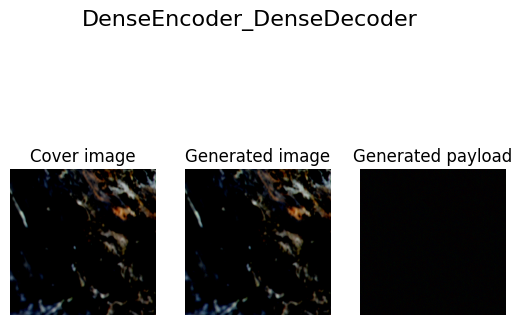

In [ ]:
cover, *rest = next(iter(valid_set))

_, H, W = cover.size()
cover = cover[None].to(device)

text = "CODE RED!!!"
payload = make_payload(W, H, data_depth, text)
payload = payload.to(device)
generated = test(encoder,decoder,data_depth,epochs,cover,payload)

text_return_ = make_message(generated)

print('Message found: ',text_return_)